# Diamond Price Prediction

## 1. Import Libraries and Dataset

In [ ]:
# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn import preprocessing, sklearn
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Exporting
import pickle

import warnings
import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
diamonds = pd.read_csv('/content/drive/MyDrive/Data DS Bootcamp/diamonds.csv')
print('diamonds data shape:', diamonds.shape)
diamonds.head(10)

diamonds data shape: (53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.50,55.00,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.80,61.00,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.90,65.00,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.40,58.00,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.30,58.00,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.80,57.00,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.30,57.00,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.90,55.00,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.10,61.00,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.40,61.00,338,4.00,4.05,2.39


cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"] <br>
color_order = ["J", "I", "H", "G", "F", "E", "D"] <br>
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"] <br>
x = length (mm)<br>
y = width (mm)<br>
z = depth (mm)<br>

## 2. EDA

In [ ]:
diamonds.info()
diamonds.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


,Unnamed: 0,carat,depth,table,price,x,y,z
count,"53,940.00","53,940.00","53,940.00","53,940.00","53,940.00","53,940.00","53,940.00","53,940.00"
mean,"26,970.50",0.80,61.75,57.46,"3,932.80",5.73,5.73,3.54
std,"15,571.28",0.47,1.43,2.23,"3,989.44",1.12,1.14,0.71
min,1.00,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,"13,485.75",0.40,61.00,56.00,950.00,4.71,4.72,2.91
50%,"26,970.50",0.70,61.80,57.00,"2,401.00",5.70,5.71,3.53
75%,"40,455.25",1.04,62.50,59.00,"5,324.25",6.54,6.54,4.04
max,"53,940.00",5.01,79.00,95.00,"18,823.00",10.74,58.90,31.80


Kolom pertama identifier<br>
Tidak ada null values <br>
Kolom "price" kemungkinan skewed

In [ ]:
# Delete index
diamonds.drop('Unnamed: 0', axis=1, inplace=True)

### 2.1. Numerical Features

In [ ]:
diamonds_num = diamonds.select_dtypes(exclude=['object'])
diamonds_num.head()

,carat,depth,table,price,x,y,z
0,0.23,61.50,55.00,326,3.95,3.98,2.43
1,0.21,59.80,61.00,326,3.89,3.84,2.31
2,0.23,56.90,65.00,327,4.05,4.07,2.31
3,0.29,62.40,58.00,334,4.20,4.23,2.63
4,0.31,63.30,58.00,335,4.34,4.35,2.75


In [ ]:
# Remove 'price' and save it
price = diamonds_num['price']
diamonds_num.drop('price', axis=1, inplace=True)
diamonds_num.head()

,carat,depth,table,x,y,z
0,0.23,61.50,55.00,3.95,3.98,2.43
1,0.21,59.80,61.00,3.89,3.84,2.31
2,0.23,56.90,65.00,4.05,4.07,2.31
3,0.29,62.40,58.00,4.20,4.23,2.63
4,0.31,63.30,58.00,4.34,4.35,2.75


In [ ]:
# constant features dihilangkan karena variansi yang rendah dalam satu feature
# Define a threshold for quasi-constant features (e.g., 95% similar values)
quasi_constant_threshold = 0.05

# Initialize the VarianceThreshold selector
selector = VarianceThreshold(
    threshold=quasi_constant_threshold
)

# Fit the selector to the numerical features (excluding the target variable 'price')
selector.fit(diamonds_num)

# Get the indices of features that are not quasi-constant
# These are the features we want to keep.
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features:
selected_feature_names = (
    diamonds_num
    .columns[selected_feature_indices]
    .tolist()
)

print(f"Selected features:")
pprint.pprint(selected_feature_names)

Selected features:
['carat', 'depth', 'table', 'x', 'y', 'z']


In [ ]:
# Get the number of features that are not constant
print(f"Number of retained features:")
print(len(selected_feature_indices))
print("/n")
print(f"Number of quasi_constant features:")
print(len(diamonds_num.columns) - len(selected_feature_indices))

Number of retained features:
6
/n
Number of quasi_constant features:
0


In [ ]:
# Merge with price
diamonds_num = diamonds_num.merge(price, left_index=True, right_index=True)
diamonds_num.head()

,carat,depth,table,x,y,z,price
0,0.23,61.50,55.00,3.95,3.98,2.43,326
1,0.21,59.80,61.00,3.89,3.84,2.31,326
2,0.23,56.90,65.00,4.05,4.07,2.31,327
3,0.29,62.40,58.00,4.20,4.23,2.63,334
4,0.31,63.30,58.00,4.34,4.35,2.75,335


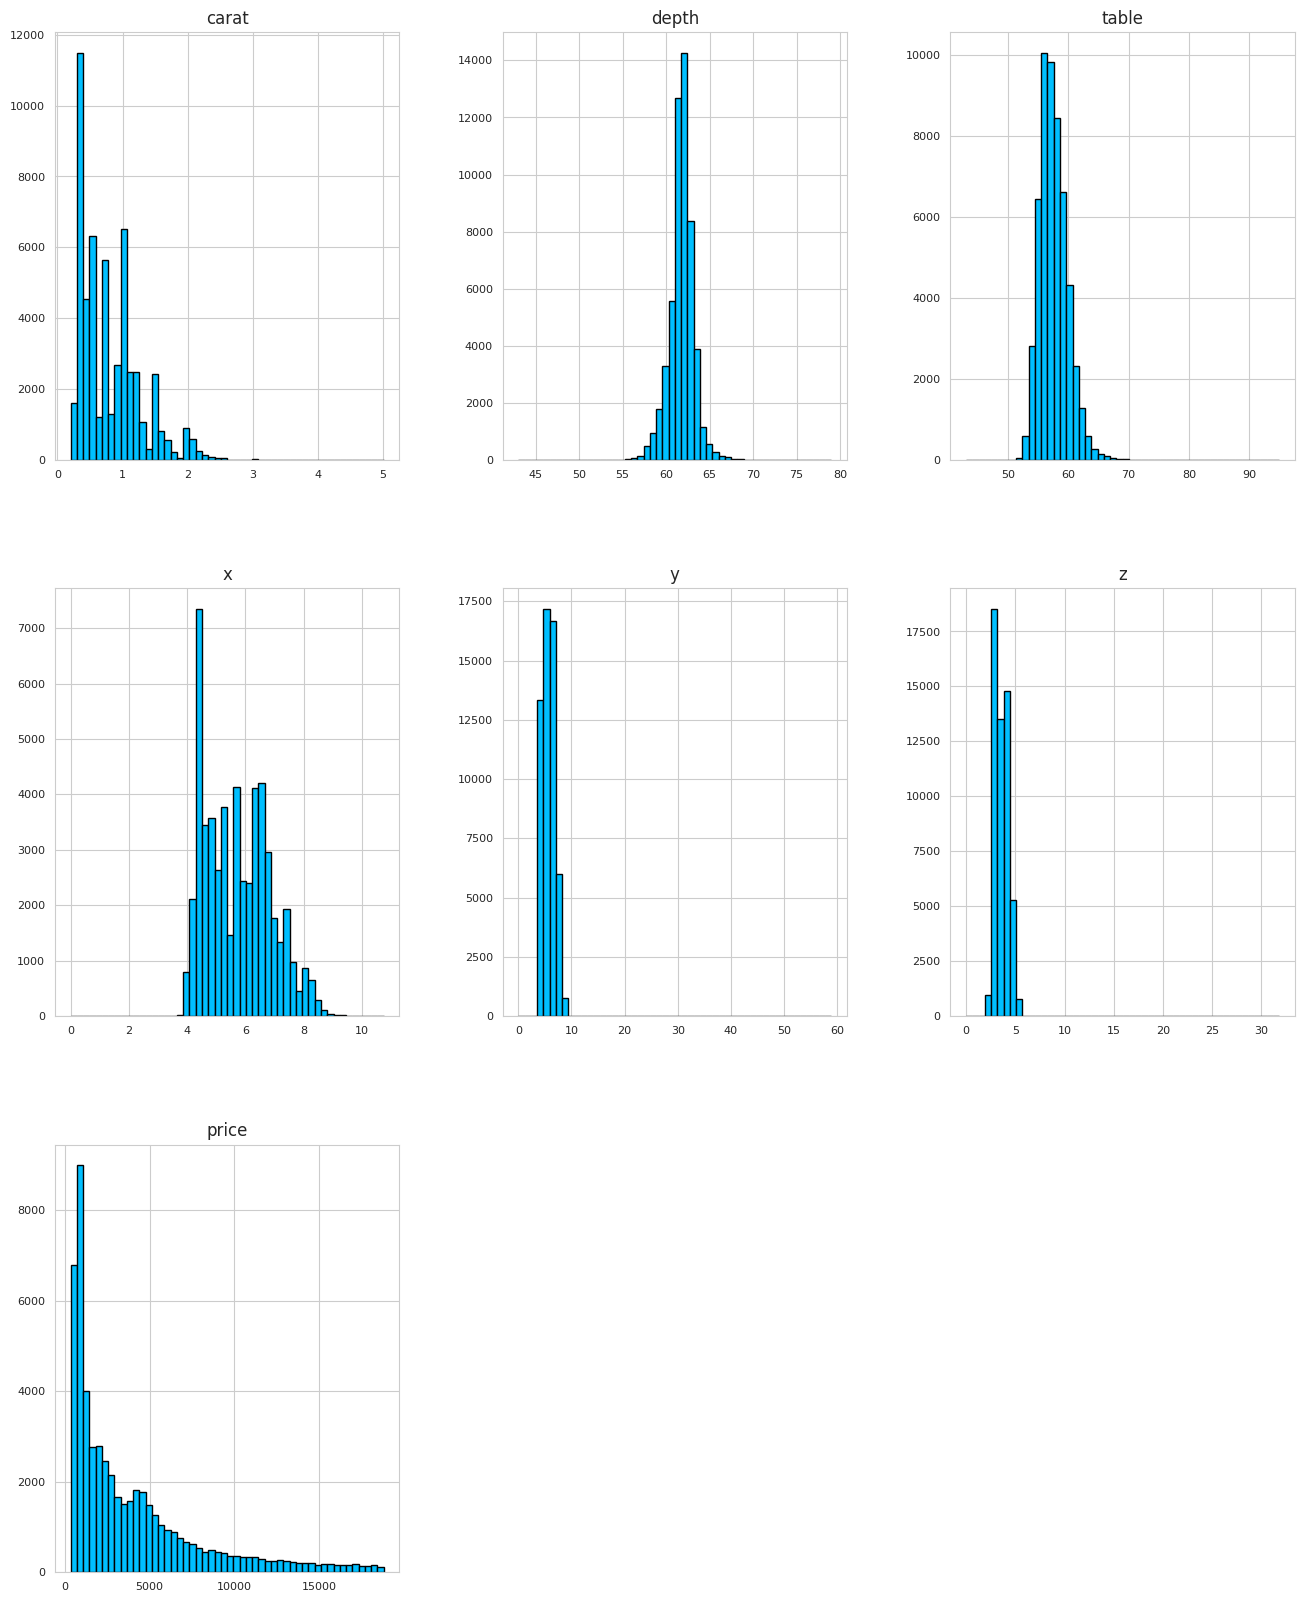

In [ ]:
# Plot distribution of all numerical data
fig_ = diamonds_num.hist(
    figsize=(16, 20),
    bins=50,
    color="deepskyblue",
    edgecolor="black",
    xlabelsize=8,
    ylabelsize=8
)

In [ ]:
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format
corr_num = diamonds_num.corr()
corr_num

,carat,depth,table,x,y,z,price
carat,1.00,0.03,0.18,0.98,0.95,0.95,0.92
depth,0.03,1.00,-0.30,-0.03,-0.03,0.09,-0.01
table,0.18,-0.30,1.00,0.20,0.18,0.15,0.13
x,0.98,-0.03,0.20,1.00,0.97,0.97,0.88
y,0.95,-0.03,0.18,0.97,1.00,0.95,0.87
z,0.95,0.09,0.15,0.97,0.95,1.00,0.86
price,0.92,-0.01,0.13,0.88,0.87,0.86,1.00


In [ ]:
# Replace correlation < |0.10| by 0 for a better visibility
# yg dicari dikorelasi yg mendekati 1 dan -1, klo lemah exclude aja, anggep 0
corr_num[(corr_num < 0.10) & (corr_num > -0.10)] = 0
corr_num

,carat,depth,table,x,y,z,price
carat,1.00,0.00,0.18,0.98,0.95,0.95,0.92
depth,0.00,1.00,-0.30,0.00,0.00,0.00,0.00
table,0.18,-0.30,1.00,0.20,0.18,0.15,0.13
x,0.98,0.00,0.20,1.00,0.97,0.97,0.88
y,0.95,0.00,0.18,0.97,1.00,0.95,0.87
z,0.95,0.00,0.15,0.97,0.95,1.00,0.86
price,0.92,0.00,0.13,0.88,0.87,0.86,1.00


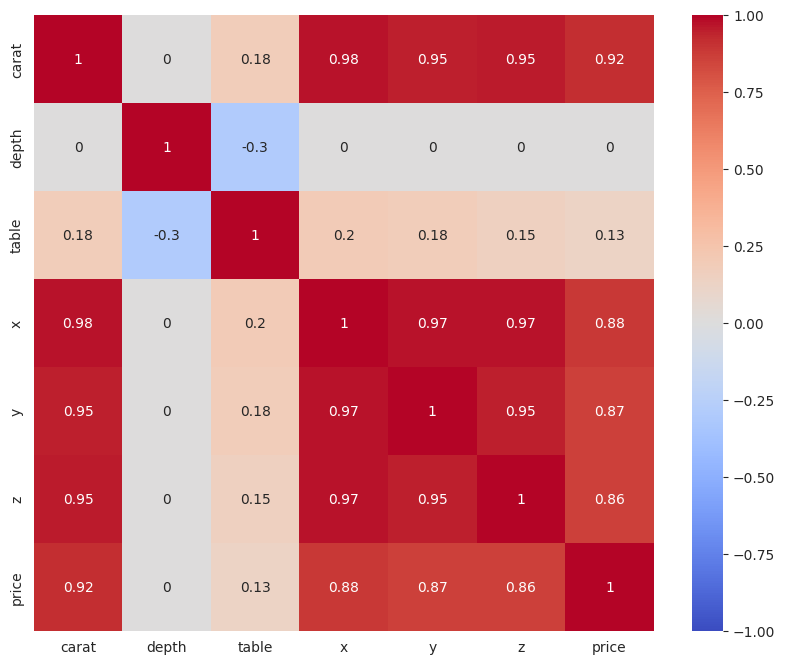

In [ ]:
# Correlation heatmap of corr_num
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    corr_num,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True
)

"depth" considered not useful (-0.01 correlation value)

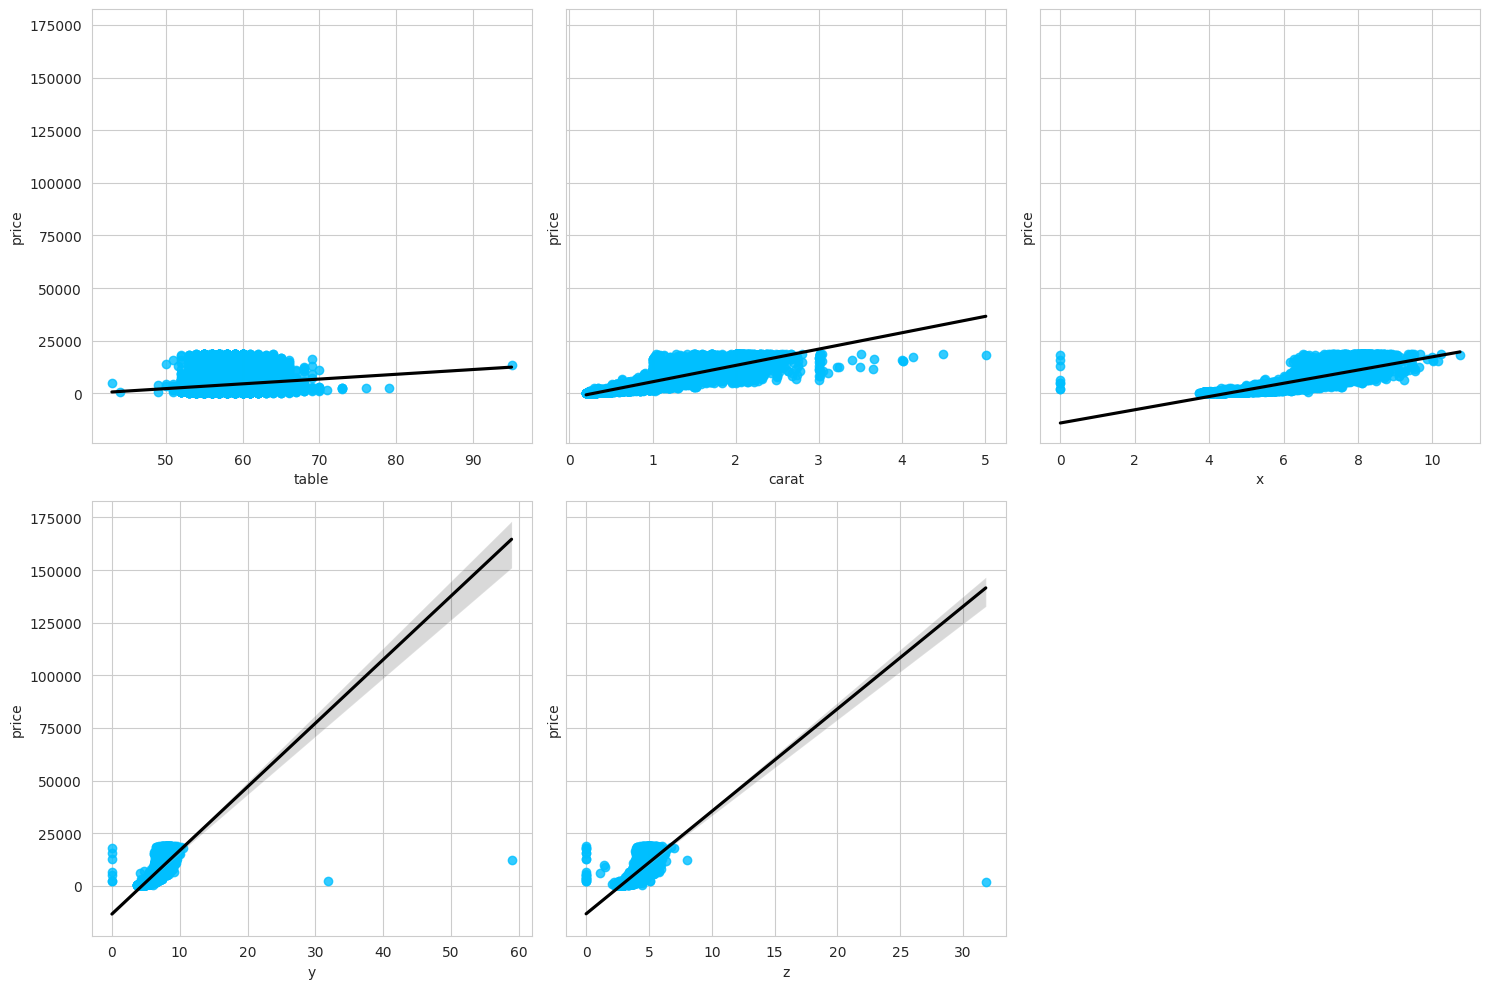

In [ ]:
# Save strong correlation with 'price'
strong_features = ['table','carat', 'x', 'y', 'z']
strong_features.append("price")
df_strong_features = diamonds_num.loc[:, strong_features]

sns.set_style("whitegrid")  # define figures style

# Calculate the number of rows and columns for subplots
n_rows = (len(strong_features) -1 + 2) // 3  # Ensure enough rows
n_cols = min(3, len(strong_features) - 1)


fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
    sharey=True
)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i in range(len(strong_features) - 1):
    sns.regplot(
        x=strong_features[i],
        y="price",
        data=df_strong_features,
        ax=axes[i],
        scatter_kws={"color": "deepskyblue"},
        line_kws={"color": "black"},
    )
    axes[i].set_xlabel(strong_features[i]) # Set xlabel for each subplot


# Turn off any unused subplots
for i in range(len(strong_features) - 1, len(axes)):
    axes[i].set_axis_off()


plt.tight_layout()
plt.show()

There are some outliers in y and z columns, need to remove them

In [ ]:
# Remove y and z > 15, also those with 0 in either x, y, or z (diamonds can't be 2D)
diamonds_num = diamonds_num[
    (diamonds_num['y'] < 15) &
    (diamonds_num['z'] < 15) &
    (diamonds_num['x'] > 0) &
    (diamonds_num['y'] > 0) &
    (diamonds_num['z'] > 0)
]

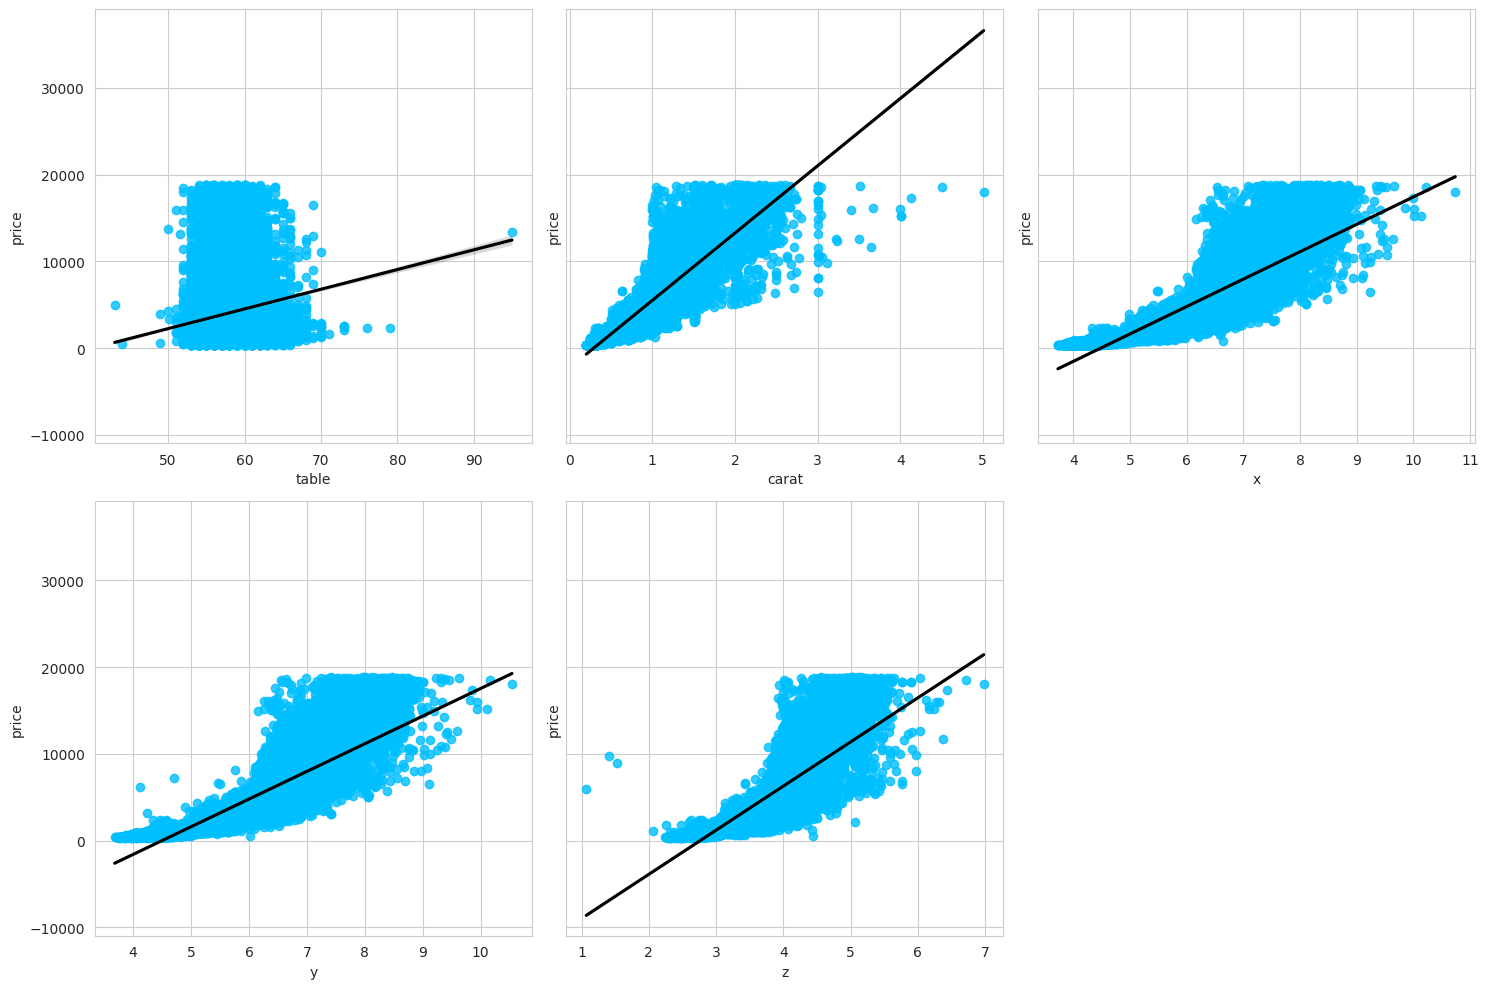

In [ ]:
# Update the graph
strong_features = ['table','carat', 'x', 'y', 'z']
strong_features.append("price")
df_strong_features = diamonds_num.loc[:, strong_features]

sns.set_style("whitegrid")  # define figures style

# Calculate the number of rows and columns for subplots
n_rows = (len(strong_features) -1 + 2) // 3  # Ensure enough rows
n_cols = min(3, len(strong_features) - 1)


fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
    sharey=True
)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i in range(len(strong_features) - 1):
    sns.regplot(
        x=strong_features[i],
        y="price",
        data=df_strong_features,
        ax=axes[i],
        scatter_kws={"color": "deepskyblue"},
        line_kws={"color": "black"},
    )
    axes[i].set_xlabel(strong_features[i]) # Set xlabel for each subplot


# Turn off any unused subplots
for i in range(len(strong_features) - 1, len(axes)):
    axes[i].set_axis_off()


plt.tight_layout()
plt.show()

It is now clear from outliers

In [ ]:
# Define the list of numerical features to keep
# ambil strong correlated
list_of_numerical_features = strong_features[:-1]

# Let's select these features from our train set
diamonds_num = diamonds_num.loc[:, list_of_numerical_features]
diamonds_num.head()

,table,carat,x,y,z
0,55.00,0.23,3.95,3.98,2.43
1,61.00,0.21,3.89,3.84,2.31
2,65.00,0.23,4.05,4.07,2.31
3,58.00,0.29,4.20,4.23,2.63
4,58.00,0.31,4.34,4.35,2.75


### 2.2. Categorical Features

In [ ]:
# Select categorical features
diamonds_cat = diamonds.select_dtypes(include=['object'])
# Append the 'price'
diamonds_cat = diamonds_cat.merge(price, left_index=True, right_index=True)
diamonds_cat.head()

,cut,color,clarity,price
0,Ideal,E,SI2,326
1,Premium,E,SI1,326
2,Good,E,VS1,327
3,Premium,I,VS2,334
4,Good,J,SI2,335


<ipython-input-76-22d5b8db23da>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-76-22d5b8db23da>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-76-22d5b8db23da>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


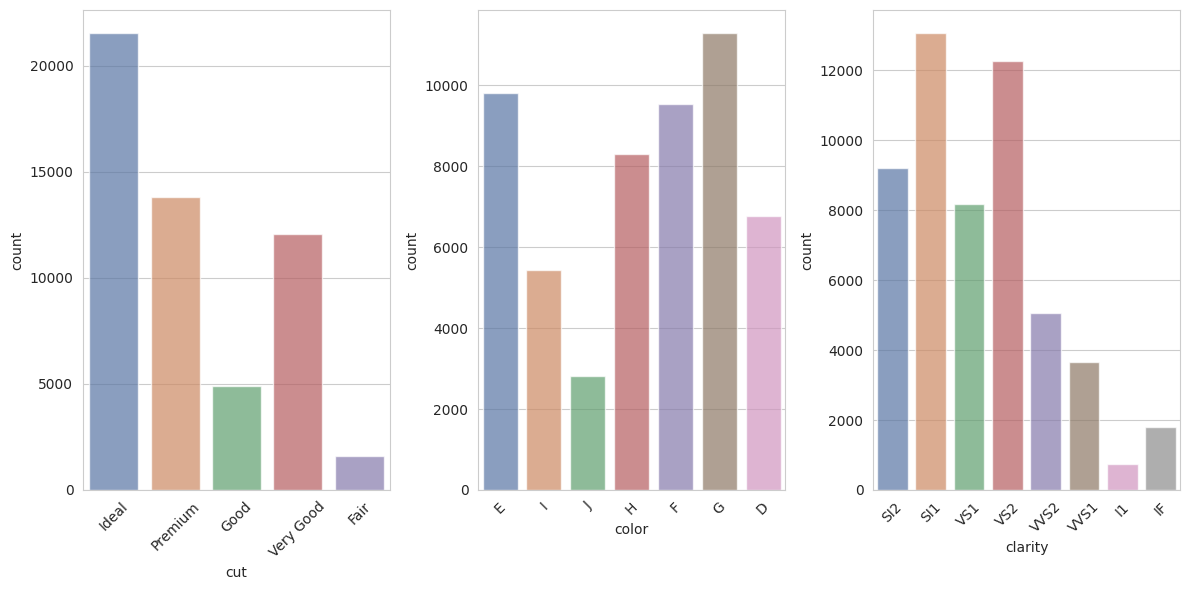

In [ ]:
# Countplot for each of the categorical features in the train set
fig, axes = plt.subplots(
    nrows=round(len(diamonds_cat.columns) / 3),
    ncols=3,
    figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):  # Iterate through flattened axes array
    if i < (len(diamonds_cat.columns)-1): # -1 because we exclude price

        sns.countplot(
            x=diamonds_cat.columns[i],
            alpha=0.7,
            data=diamonds_cat,
            palette="deep",
            ax=ax
        )

        ax.tick_params(
            axis='x',
            rotation=45
        )
    else:
        ax.set_axis_off() # Hide empty subplots

fig.tight_layout()
plt.show()

### 2.3. Merge both num and cat for modeling preparation

In [ ]:
# Merge num and cat data
diamonds_new = diamonds_num.merge(diamonds_cat, left_index=True, right_index=True)
diamonds_new.head()

,table,carat,x,y,z,cut,color,clarity,price
0,55.00,0.23,3.95,3.98,2.43,Ideal,E,SI2,326
1,61.00,0.21,3.89,3.84,2.31,Premium,E,SI1,326
2,65.00,0.23,4.05,4.07,2.31,Good,E,VS1,327
3,58.00,0.29,4.20,4.23,2.63,Premium,I,VS2,334
4,58.00,0.31,4.34,4.35,2.75,Good,J,SI2,335


## 3. Data Preparation for Modelling (Feature Engineering)

### 3.1. Label Encoding (Ordinal Encoder)

In [ ]:
# Label encode on categorical features
# Urutan mulai dari 0 (paling rendah)
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_order = ["J", "I", "H", "G", "F", "E", "D"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])

# Apply encoding to categorical features (data objek)
diamonds_new[['cut', 'color', 'clarity']] = encoder.fit_transform(diamonds_new[['cut', 'color', 'clarity']])
diamonds_new.head(10)

,table,carat,x,y,z,cut,color,clarity,price
0,55.00,0.23,3.95,3.98,2.43,4.00,5.00,1.00,326
1,61.00,0.21,3.89,3.84,2.31,3.00,5.00,2.00,326
2,65.00,0.23,4.05,4.07,2.31,1.00,5.00,4.00,327
3,58.00,0.29,4.20,4.23,2.63,3.00,1.00,3.00,334
4,58.00,0.31,4.34,4.35,2.75,1.00,0.00,1.00,335
5,57.00,0.24,3.94,3.96,2.48,2.00,0.00,5.00,336
6,57.00,0.24,3.95,3.98,2.47,2.00,1.00,6.00,336
7,55.00,0.26,4.07,4.11,2.53,2.00,2.00,2.00,337
8,61.00,0.22,3.87,3.78,2.49,0.00,5.00,3.00,337
9,61.00,0.23,4.00,4.05,2.39,2.00,2.00,4.00,338


### 3.2. Data Transformation

Text(0.5, 1.0, 'Transformed Price Distribution')

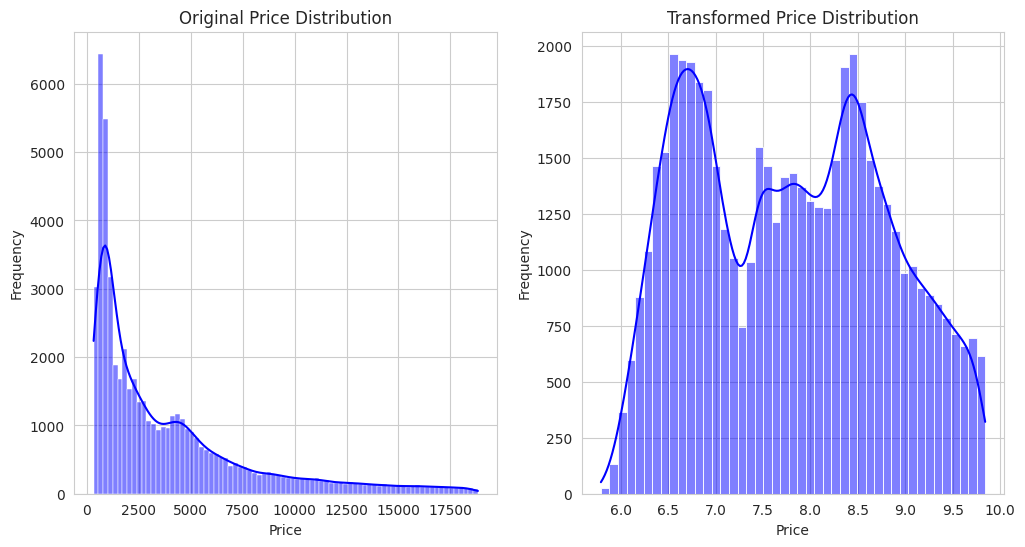

In [ ]:
# Visualize the distribution of prices using histogram, side by side compared with log transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(diamonds_new['price'], kde=True, color='blue')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Original Price Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(diamonds['price']), kde=True, color='blue')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Transformed Price Distribution')

In [ ]:
# Change the 'price' to 'log_price'
diamonds_new['log_price'] = np.log1p(diamonds_new['price'])
diamonds_new = diamonds_new.drop('price', axis=1)
diamonds_new.head()

,table,carat,x,y,z,cut,color,clarity,log_price
0,55.00,0.23,3.95,3.98,2.43,4.00,5.00,1.00,5.79
1,61.00,0.21,3.89,3.84,2.31,3.00,5.00,2.00,5.79
2,65.00,0.23,4.05,4.07,2.31,1.00,5.00,4.00,5.79
3,58.00,0.29,4.20,4.23,2.63,3.00,1.00,3.00,5.81
4,58.00,0.31,4.34,4.35,2.75,1.00,0.00,1.00,5.82


### 3.3. Data Splitting and Standardization

In [ ]:
# Extract the features (X) and the target (y)

# Features (X)
predictors = [i for i in list(diamonds_new.columns) if i != "log_price"]
X = diamonds_new[predictors]
print(X.shape)

# Target (y)
y = diamonds_new.loc[:, "log_price"]
print(y.shape)

(53917, 8)
(53917,)


In [ ]:
# Split into X_train and X_test (by stratifying on y)
# Stratify on a continuous variable by splitting it in bins
# Create the bins to convert continuous to categories for stratification
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y_binned,
    shuffle=True,
    random_state=42
)

print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(43133, 8)
y_train:(43133,)

X_test:(10784, 8)
y_test:(10784,)


In [ ]:
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# The output of standardization is a vector. Let's turn it into a table
# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

In [ ]:
# Save the column names used for training
feature_columns = X_train.columns.tolist()
print(feature_columns)

['table', 'carat', 'x', 'y', 'z', 'cut', 'color', 'clarity']


### 3.4. VIF

In [ ]:
# Here we calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,1.60,table
1,24.80,carat
2,429.10,x
3,384.20,y
4,76.00,z
5,1.50,cut
6,1.10,color
7,1.20,clarity


Severe multicollinearity, but dropping those features may affect models since we only have little features. <br>
Solution: use tree-based model that have a little effect to multicollinearity

## 4. Modeling

In [ ]:
# Define a function for each metrics
# R²
def rsqr_score(test, pred):
    """Calculate R squared score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_

# Real RMSE
def real_rmse(test, pred):
    """Calculate Root Mean Square Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    real_test = np.expm1(test)
    real_pred = np.expm1(pred)
    real_rmse_ = np.sqrt(mean_squared_error(real_test, real_pred))
    return real_rmse_

# MAE
def mae_score(test, pred):
    """Calculate Mean Absolute Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Mean Absolute Error score
    """
    mae_ = mean_absolute_error(test, pred)
    return mae_

# Real MAE
def real_mae(test, pred):
    """Calculate Mean Absolute Error score (original scale)

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Mean Absolute Error score (original scale)
    """
    real_test = np.expm1(test)
    real_pred = np.expm1(pred)
    real_mae_= mean_absolute_error(real_test, real_pred)
    return real_mae_

# MAPE
def mape_score(test, pred):
    """Calculate Mean Absolute Percentage Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Mean Absolute Percentage Error score
    """
    test = np.array(test).ravel()
    pred = np.array(pred).ravel()
    non_zero_mask = test != 0
    test = test[non_zero_mask]
    pred = pred[non_zero_mask]
    mape_ = np.mean(np.abs((test - pred) / test)) * 100
    return mape_

# Print the scores
def print_score(test, pred):
    """Print calculated score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
        print Mean Absolute Error score
    """

    print(f"- Regressor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")
    print(f"MAE: {mae_score(test, pred)}\n")
    print(f"MAPE: {mape_score(test, pred)}\n")

In [ ]:
# Define regression models
dtr =  DecisionTreeRegressor()
ridge = Ridge()
lasso = Lasso(alpha=0.001)
elastic = ElasticNet(alpha=0.001)
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()

# Train models on X_train and y_train
for regr in [dtr, ridge, lasso, elastic, rdf, xgboost, lgbm]:
    # fit the corresponding model
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # Print the defined metrics above for each classifier
    print_score(y_test, y_pred)

- Regressor: DecisionTreeRegressor
R²: 0.9851849303643938
RMSE: 0.12378088370405052

MAE: 0.08338281860576756

MAPE: 1.0690132369765428

- Regressor: Ridge
R²: 0.9790748844946796
RMSE: 0.14710778701444135

MAE: 0.11347738996426349

MAPE: 1.4814753125956384

- Regressor: Lasso
R²: 0.9788696105614526
RMSE: 0.14782758463032775

MAE: 0.11397532367688692

MAPE: 1.4866605822975387

- Regressor: ElasticNet
R²: 0.9789401104067156
RMSE: 0.147580771165368

MAE: 0.11383371295221983

MAPE: 1.4859263730190237



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


- Regressor: RandomForestRegressor
R²: 0.9922238830452877
RMSE: 0.08967742352280819

MAE: 0.06276762539355187

MAPE: 0.8081589385224233

- Regressor: XGBRegressor
R²: 0.9922670125961304
RMSE: 0.0894284601648029

MAE: 0.06415467709302902

MAPE: 0.8258599649469687

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 43133, number of used features: 8
[LightGBM] [Info] Start training from score 7.788400
- Regressor: LGBMRegressor
R²: 0.9920652990445556
RMSE: 0.09058723672862225

MAE: 0.06549877352239289

MAPE: 0.8469422025085339



Choose which model have high R2:
- Random Forest
- XGB
- LGBM

### 4.1. Hyperparameters Tuning and Optimization

In [ ]:
model_list = []
r2_list = []
rmse_list = []
mae_list = []
mape_list = []
real_rmse_list = []
real_mae_list = []

#### 4.1.1. Random Forest

In [ ]:
# Define hyperparameters (tunable)
tuned_parameters = {
    "max_depth": [3, 5, 7],
    "bootstrap": [True, False],
    "max_features": ['auto', 'log2', 'sqrt'],
    "n_estimators": [300, 500]
}

# GridSearch
rf_cv = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=tuned_parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit the GridSearch on train set
rf_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {rf_cv.best_params_}\n")
print(f"Best R²: {rf_cv.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best hyperparameters: {'bootstrap': True, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 300}

Best R²: 0.9798312870574968


In [ ]:
# Random Forest Regressor with the best hyperparameters
rf_mod = RandomForestRegressor(
    max_depth=rf_cv.best_params_["max_depth"],
    bootstrap=rf_cv.best_params_["bootstrap"],
    max_features=rf_cv.best_params_["max_features"],
    n_estimators=rf_cv.best_params_["n_estimators"]
)

# Fit the model on train set
rf_mod.fit(X_train, y_train)

# Predict on test set
y_pred = rf_mod.predict(X_test)

print(f"- {rf_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")
print(f"MAE: {mae_score(y_test, y_pred)}")
print(f"MAPE: {mape_score(y_test, y_pred)}")
print(f"Real RMSE: {real_rmse(y_test, y_pred)}")
print(f"Real MAE: {real_mae(y_test, y_pred)}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


- RandomForestRegressor
R²: 0.9797636988825873
RMSE: 0.1446662743003976
MAE: 0.11072077210777508
MAPE: 1.452254170471724
Real RMSE: 867.0494144062828
Real MAE: 446.3279432892295


In [ ]:
# Save the model results into lists
model_list.append(rf_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))
mae_list.append(round(mae_score(y_test, y_pred), 4))
mape_list.append(round(mape_score(y_test, y_pred), 4))
real_rmse_list.append(round(real_rmse(y_test, y_pred), 4))
real_mae_list.append(round(real_mae(y_test, y_pred), 4))

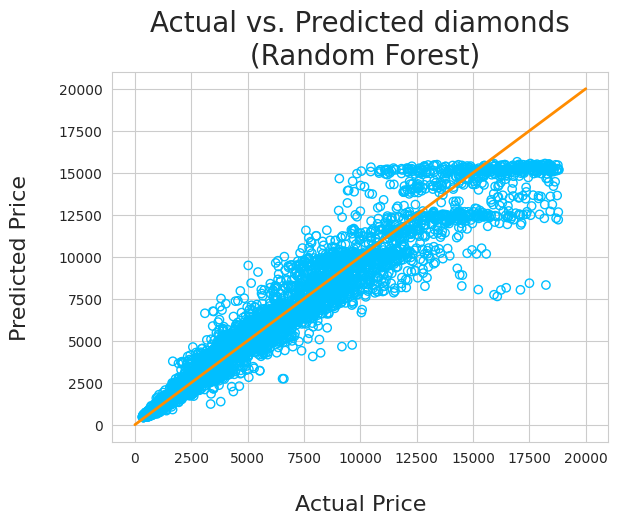

In [ ]:
# Plot Actual vs. Predicted house prices
actual_price = np.expm1(y_test["log_price"])
predicted_price = np.expm1(y_pred)

plt.figure()
plt.title("Actual vs. Predicted diamonds\n (Random Forest)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 20000], [0,20000], "darkorange", lw=2)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### 4.1.2. XGB

In [ ]:
# Define hyperparameters (tunable)
tuned_parameters = {
    "max_depth": [3, 5, 7],
    "subsample": [0.3, 0.7],
    "colsample_bytree": [0.3, 0.7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500]
}

# GridSearch
xgbr_cv = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=tuned_parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}

Best R²: 0.9929254293441773


In [ ]:
# XGB Regressor with the best hyperparameters
xgbr_mod = XGBRegressor(
    seed=20,
    colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
    #subsample=xgbr_cv.best_params_["subsample"],
    learning_rate=xgbr_cv.best_params_["learning_rate"],
    max_depth=xgbr_cv.best_params_["max_depth"],
    n_estimators=xgbr_cv.best_params_["n_estimators"]
)

# Fit the model on train set
xgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")
print(f"MAE: {mae_score(y_test, y_pred)}")
print(f"MAPE: {mape_score(y_test, y_pred)}")
print(f"Real RMSE: {real_rmse(y_test, y_pred)}")
print(f"Real MAE: {real_mae(y_test, y_pred)}")

- XGBRegressor
R²: 0.9929084777832031
RMSE: 0.08563894190541138
MAE: 0.06058954447507858
MAPE: 0.7789650194963811
Real RMSE: 537.6581453395828
Real MAE: 262.93170166015625


In [ ]:
# Save the model results into lists
model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))
mae_list.append(round(mae_score(y_test, y_pred), 4))
mape_list.append(round(mape_score(y_test, y_pred), 4))
real_rmse_list.append(round(real_rmse(y_test, y_pred), 4))
real_mae_list.append(round(real_mae(y_test, y_pred), 4))

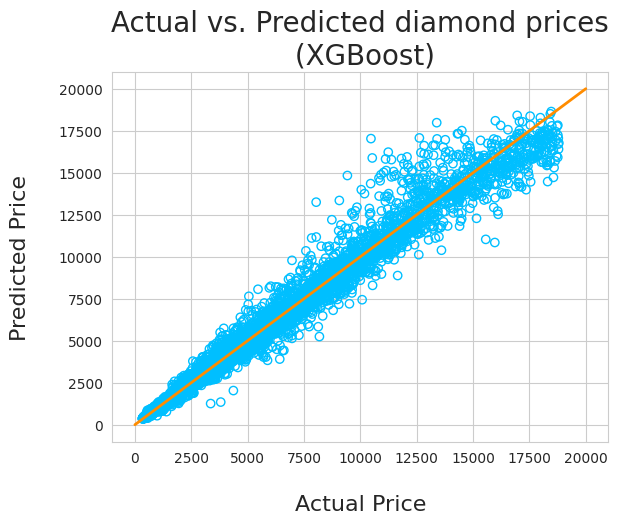

In [ ]:
# Plot Actual vs. Predicted house prices
actual_price = np.expm1(y_test["log_price"])
predicted_price = np.expm1(y_pred)

plt.figure()
plt.title("Actual vs. Predicted diamond prices\n (XGBoost)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 20000], [0,20000], "darkorange", lw=2)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### 4.1.3. LGBM

In [ ]:
# Define hyperparameters (tunable)
tuned_parameters = {
    "max_depth": [3, 5, 7],
    "bagging_fraction": [0.3, 0.7],
    "feature_fraction": [0.3, 0.7],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_iterations": [300, 500]
}

# GridSearch
lgbr_cv = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid=tuned_parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit the GridSearch on train set
lgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R2
print(f"Best hyperparameters: {lgbr_cv.best_params_}\n")
print(f"Best R²: {lgbr_cv.best_score_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 43133, number of used features: 8
[LightGBM] [Info] Start training from score 7.788400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [ ]:
# LightGBM with best hyperparams
lgbr_mod = LGBMRegressor(
    seed=20,
    #bagging_fraction=lgbr_cv.best_params_["bagging_fraction"],
    feature_fraction=lgbr_cv.best_params_["feature_fraction"],
    learning_rate=lgbr_cv.best_params_["learning_rate"],
    max_depth=lgbr_cv.best_params_["max_depth"],
    num_iterations=lgbr_cv.best_params_["num_iterations"]
)

# Fit model on train set
lgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = lgbr_mod.predict(X_test)

print(f"- {lgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")
print(f"MAE: {mae_score(y_test, y_pred)}")
print(f"MAPE: {mape_score(y_test, y_pred)}")
print(f"Real RMSE: {real_rmse(y_test, y_pred)}")
print(f"Real MAE: {real_mae(y_test, y_pred)}")

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 43133, number of used features: 8
[LightGBM] [Info] Start training from score 7.788400


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Save model to list (append)
model_list.append(lgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))
mae_list.append(round(mae_score(y_test, y_pred), 4))
mape_list.append(round(mape_score(y_test, y_pred), 4))
real_rmse_list.append(round(real_rmse(y_test, y_pred), 4))
real_mae_list.append(round(real_mae(y_test, y_pred), 4))

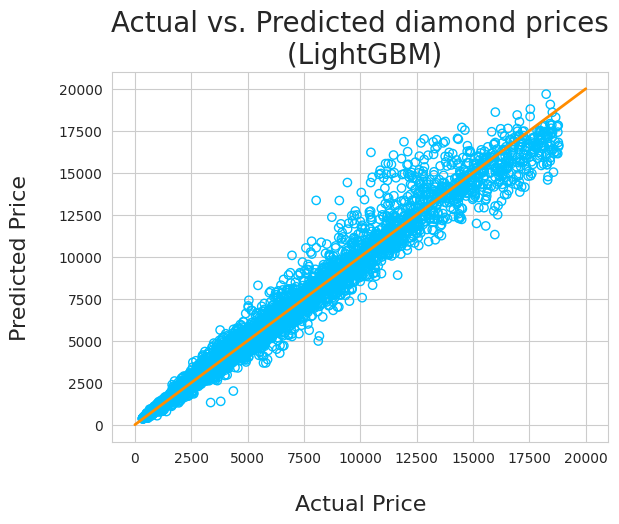

In [ ]:
# Plot actual vs predicted house price with lgbm
actual_price = np.expm1(y_test["log_price"])
predicted_price = np.expm1(y_pred)

plt.figure()
plt.title("Actual vs. Predicted diamond prices\n (LightGBM)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", facecolors="none")
plt.plot([0, 20000], [0, 20000], "darkorange", lw=2)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

### 4.2. Choose Best Model

In [ ]:
# Create a table with pd.DataFrame
model_results = pd.DataFrame(
    {
        "Model Name": model_list,
        "R² (log)": r2_list,
        "RMSE (log)": rmse_list,
        "MAE (log)": mae_list,
        "MAPE (log)": mape_list,
        "Real RMSE": real_rmse_list,
        "Real MAE": real_mae_list
    }
)

model_results

,Model Name,R² (log),RMSE (log),MAE (log),MAPE (log),Real RMSE,Real MAE
0,RandomForestRegressor,0.98,0.14,0.11,1.45,867.05,446.33
1,XGBRegressor,0.99,0.09,0.06,0.78,537.66,262.93
2,LGBMRegressor,0.99,0.09,0.06,0.78,538.49,264.76


In [ ]:
# sort by R² (log)
best_model = model_results.sort_values(by="R² (log)", ascending=False)
best_model

,Model Name,R² (log),RMSE (log),MAE (log),MAPE (log),Real RMSE,Real MAE
1,XGBRegressor,0.99,0.09,0.06,0.78,537.66,262.93
2,LGBMRegressor,0.99,0.09,0.06,0.78,538.49,264.76
0,RandomForestRegressor,0.98,0.14,0.11,1.45,867.05,446.33


#### 4.2.1. Cross-Validation test

In [ ]:
from sklearn.model_selection import cross_val_predict, KFold
def evaluate_model_cv(model, X, y_log, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Cross-validated predictions
    y_pred_log = cross_val_predict(model, X, y, cv=kf)

    # Original scale
    y_true = np.expm1(y_log)
    y_pred = np.expm1(y_pred_log)

    # Metrics
    r2 = r2_score(y_log, y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_log, y_pred_log))
    mae = mean_absolute_error(y_log, y_pred_log)

    real_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    real_mae = mean_absolute_error(y_true, y_pred)

    return {
        'R² (log)': round(r2, 4),
        'RMSE (log)': round(rmse, 4),
        'MAE (log)': round(mae, 4),
        'Real RMSE': round(real_rmse, 2),
        'Real MAE': round(real_mae, 2)
    }


In [ ]:
results_cv = pd.DataFrame([
    {'Model': 'LGBM', **evaluate_model_cv(lgbr_mod, X, y)},
    {'Model': 'XGB', **evaluate_model_cv(xgbr_mod, X, y)}
])

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 43133, number of used features: 8
[LightGBM] [Info] Start training from score 7.787954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 43133, number of used features: 8
[LightGBM] [Info] Start training from score 7.787641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1122
[LightGBM] [Info] Number of data points in the train set: 43134, number of used features: 8
[LightGBM] [Info] Start training from score 7.788596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 43134, number of used features: 8
[LightGBM] [Info] Start training from score 7.782504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 43134, number of used features: 8
[LightGBM] [Info] Start training from score 7.788429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [ ]:
results_cv

,Model,R² (log),RMSE (log),MAE (log),Real RMSE,Real MAE
0,LGBM,0.99,0.09,0.06,526.98,262.65
1,XGB,0.99,0.08,0.06,526.31,260.38


Best model = XGBRegressor <br>
Lower RMSE = minimize large errors (*since it has been log-transformed, RMSE is the main metrics (less sensitive to outliers, because of transformation)*)<br>
Lower MAE = more consistent <br>
Both are lower for XGB model, thus XGB will be used for the final model

### 4.3. Test w/ Custom Price

In [ ]:
def predict_custom_price_lgbr(custom_input, scaler, lgbr_mod, feature_columns):
    # Convert to DataFrame
    df_pred = pd.DataFrame([custom_input])

    # Drop any extra columns the model wasn't trained on
    df_pred = df_pred.drop(columns=['depth'], errors='ignore')

    # Encode ordinal features (ordinal encode)
    cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
    color_order = ["J", "I", "H", "G", "F", "E", "D"]
    clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
    encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])

    df_pred[['cut', 'color', 'clarity']] = encoder.fit_transform(df_pred[['cut', 'color', 'clarity']])

    # Reindex to match training feature columns (fill missing with 0)
    df_pred = df_pred.reindex(columns=feature_columns, fill_value=0)

    # Scale
    df_pred = scaler.transform(df_pred)

    # Predict log(price) and convert back
    model = lgbr_mod
    log_pred = model.predict(df_pred)
    predicted_price = np.expm1(log_pred)[0]

    return predicted_price

def predict_custom_price_xgbr(custom_input, scaler, xgbr_mod, feature_columns):
    # Convert to DataFrame
    df_pred = pd.DataFrame([custom_input])

    # Drop any extra columns the model wasn't trained on
    df_pred = df_pred.drop(columns=['depth'], errors='ignore')

    # Encode ordinal features (ordinal encode)
    cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
    color_order = ["J", "I", "H", "G", "F", "E", "D"]
    clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
    encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])

    df_pred[['cut', 'color', 'clarity']] = encoder.fit_transform(df_pred[['cut', 'color', 'clarity']])

    # Reindex to match training feature columns (fill missing with 0)
    df_pred = df_pred.reindex(columns=feature_columns, fill_value=0)

    # Scale
    df_pred = scaler.transform(df_pred)

    # Predict log(price) and convert back
    model = xgbr_mod
    log_pred = model.predict(df_pred)
    predicted_price = np.expm1(log_pred)[0]

    return predicted_price

In [ ]:
my_diamond = {
    'carat': 0.72,
    'cut': 'Good',
    'color': 'D',
    'clarity': 'VS2',
    'depth': 64,
    'table': 54,
    'x': 5.68,
    'y': 5.7,
    'z': 3.64
}

predicted_price = predict_custom_price_lgbr(my_diamond, scaler, lgbr_mod, feature_columns)
print(f"Estimated Price (LGB): $", predicted_price)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Estimated Price (LGB): $ 3038.393762183834


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
my_diamond = {
    'carat': 0.72,
    'cut': 'Good',
    'color': 'D',
    'clarity': 'VS2',
    'depth': 64,
    'table': 54,
    'x': 5.68,
    'y': 5.7,
    'z': 3.64
}

predicted_price = predict_custom_price_xgbr(my_diamond, scaler, xgbr_mod, feature_columns)
print(f"Estimated Price (XGB): $", predicted_price)

Estimated Price (XGB): $ 3032.7515


From estimated price result, XGB more near the actual price

In [ ]:
diamonds.iloc[537]
#cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
#color_order = ["J", "I", "H", "G", "F", "E", "D"]
#clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

,537
carat,0.72
cut,Good
color,D
clarity,VS2
depth,64.00
table,54.00
price,2827
x,5.68
y,5.70
z,3.64


## 5. Save Model

In [ ]:
# Save model to file
with open("xgbr_model.pkl", "wb") as file:
    pickle.dump(xgbr_mod, file)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)

with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

======================================================================================

# Below, use TensorFlow (not used)

### Linear Regression Model

In [ ]:
# Build model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16),
    layers.Dense(1)
])

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer='adam', loss='mse', metrics=[rmse])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_rmse',       # yang dilihat
    patience=5,
    mode='min',
    restore_best_weights=True  # restore the best model
)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 6.3736 - rmse: 1.7833 - val_loss: 0.1006 - val_rmse: 0.2418
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4293 - rmse: 0.6249 - val_loss: 0.0279 - val_rmse: 0.1624
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3021 - rmse: 0.5405 - val_loss: 0.0229 - val_rmse: 0.1457
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2032 - rmse: 0.4457 - val_loss: 0.0313 - val_rmse: 0.1751
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1162 - rmse: 0.3355 - val_loss: 0.0261 - val_rmse: 0.1583
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0564 - rmse: 0.2252 - val_loss: 0.0190 - val_rmse: 0.1336
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0334 - rmse: 0.1796 - val_loss: 0.0143 - val_rmse: 0.1165
Epoch 8/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0297 - rmse: 0.1698 - val_loss: 0.0180 - val_rmse: 0.1328
Epoch 9/50
1079/1079 ━━

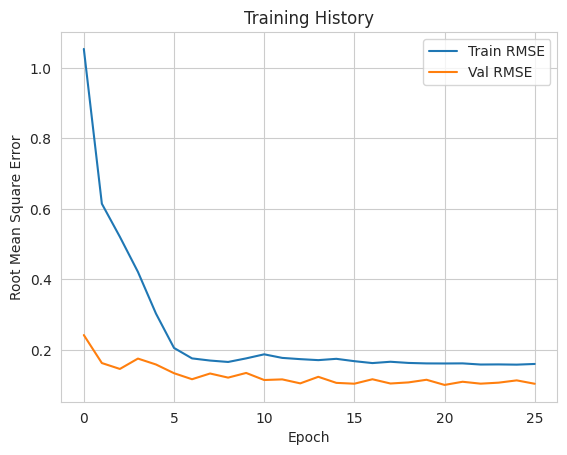

In [ ]:
# Model Training Curve
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
plt.title('Training History')
plt.legend()
plt.show()

In [ ]:
# Evaluate
# Predict, need to inverse the prediction to show actual price prediction (not transformed)
y_pred_log = model.predict(X_test).ravel()
y_pred_log = np.clip(y_pred_log, a_min=0, a_max=10)  # Prevent extreme predictions
y_true_log = y_test.values.ravel()

mse_log = mean_squared_error(y_true_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
print(f"Log-Scale RMSE: {rmse_log:.4f}")

# Inverse transform
y_pred = np.expm1(y_pred_log).ravel()
y_true = np.expm1(y_test.values.ravel())

# Evaluate
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("Predicted: ", y_pred)
print("Actual: ", y_true)
print(f'Prediction MAE: {mae}')
print(f'Prediction MAPE: {mape}')
print(f'Prediction MSE: {mse}')
print(f'Prediction RMSE: {rmse_score}')

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Log-Scale RMSE: 0.1164
Predicted:  [ 1118.0107  5020.0137  1242.4395 ... 11727.563   1546.5186  7475.7305]
Actual:  [ 1076.  4682.  1343. ... 12089.  1624.  7751.]
Prediction MAE: 292.9122109006943
Prediction MAPE: 7.560103879080765
Prediction MSE: 369541.65768204356
Prediction RMSE: 557.9215334614717


MSE RMSE to the moon :D

<ipython-input-143-d652ed3dd697>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


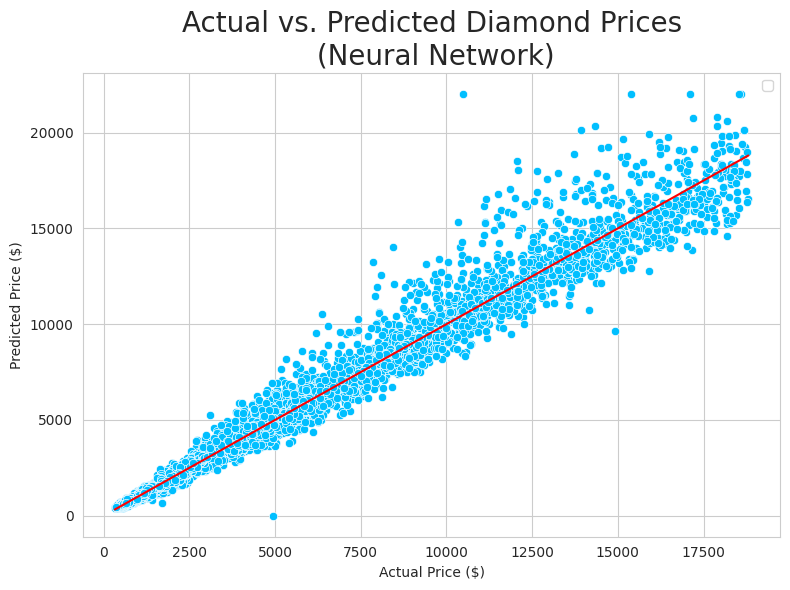

In [ ]:
# Create dataframe for plotting y_pred and y_true
df_plot = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

# Plot "Predicted" (y_pred) vs "Actual" (y_true)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=df_plot, color='deepskyblue')

# Add a reference line (perfect prediction)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='-')

# Plot aesthetics
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs. Predicted Diamond Prices\n (Neural Network)', fontsize=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Test w/Custom Input


In [ ]:
def predict_custom_price_nn(custom_input, encoder, scaler, model, feature_columns):
    # Convert to DataFrame
    df = pd.DataFrame([custom_input])

    # Drop any extra columns the model wasn't trained on
    df = df.drop(columns=['depth', 'table'], errors='ignore')

    # Encode ordinal features
    df[['cut', 'color', 'clarity']] = encoder.transform(df[['cut', 'color', 'clarity']])

    # Reindex to match training feature columns (fill missing with 0)
    df = df.reindex(columns=feature_columns, fill_value=0)

    # Scale
    df = scaler.transform(df)

    # Predict log(price) and convert back
    log_pred = model.predict(df)
    predicted_price = np.expm1(log_pred)[0][0]

    return predicted_price

In [ ]:
my_diamond = {
    'carat': 0.70,
    'cut': 'Ideal',
    'color': 'H',
    'clarity': 'VVS1',
    'depth': 62.30,
    'table': 55,
    'x': 5.66,
    'y': 5.7,
    'z': 3.54
}

predicted_price = predict_custom_price_nn(my_diamond, encoder, scaler, model, feature_columns)
print(f"Estimated Price: $", predicted_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Estimated Price: $ 2860.148


The real and estimated price is near the same, but the MSE and MAE is huge (idk why, pls help)

In [ ]:
diamonds.iloc[540]
#cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
#color_order = ["J", "I", "H", "G", "F", "E", "D"]
#clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

,540
carat,0.70
cut,Ideal
color,H
clarity,VVS1
depth,62.30
table,55.00
price,2827
x,5.66
y,5.70
z,3.54


### Save Model

In [ ]:
# Simpan model pickle
pickle.dump(model, open('Lin_reg_model_nn.pkl','wb'))